In [2]:
import pandas as pd
import numpy as np
import joblib
import os

In [3]:
train_01 = joblib.load('../../3.HA_model/1.PCA_T2/train_HA_feature/train_01.lz4')
train_02 = joblib.load('../../3.HA_model/1.PCA_T2/train_HA_feature/train_02.lz4')
train_03 = joblib.load('../../3.HA_model/1.PCA_T2/train_HA_feature/train_03.lz4')

test_01 = joblib.load('../../3.HA_model/1.PCA_T2/test_HA_feature/test_01.lz4')
test_02 = joblib.load('../../3.HA_model/1.PCA_T2/test_HA_feature/test_02.lz4')
test_03 = joblib.load('../../3.HA_model/1.PCA_T2/test_HA_feature/test_03.lz4')
test_04 = joblib.load('../../3.HA_model/1.PCA_T2/test_HA_feature/test_04.lz4')
test_05 = joblib.load('../../3.HA_model/1.PCA_T2/test_HA_feature/test_05.lz4')

In [312]:
train = pd.concat([train_01, train_02, train_03], axis=0)
y_train = train[['RULR']]
# use_cols = ['PCA_T2__mean', 'PCA_T2__mean_diff', 'PCA_T2__delta', 'PCA_T2__delta_diff']
use_cols = ['PCA_T2__mean', 'PCA_T2__mean_diff', 'PCA_T2__delta']
x_train = train[use_cols]

test = pd.concat([test_01, test_02, test_03, test_04, test_05], axis=0)
# use_cols = ['PCA_T2__mean', 'PCA_T2__mean_diff', 'PCA_T2__delta', 'PCA_T2__delta_diff']
use_cols = ['PCA_T2__mean', 'PCA_T2__mean_diff', 'PCA_T2__delta']
x_test = test[use_cols]

In [313]:
from lightgbm.sklearn import LGBMRegressor

reg = LGBMRegressor(boosting_type='gbdt', num_leaves=100, max_depth=50, learning_rate=0.1,
              n_estimators=500, max_bin=100, objective='regression', 
              min_split_gain=0.01, min_child_weight=0.001, min_child_samples=1, subsample=1.0, 
              subsample_freq=1, colsample_bytree=0.9, reg_alpha=0.5, reg_lambda=0.5, 
              random_state=2018, n_jobs=12, silent=False)

In [315]:
reg.fit(x_train, y_train.values.reshape(-1))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       learning_rate=0.1, max_bin=100, max_depth=50, min_child_samples=1,
       min_child_weight=0.001, min_split_gain=0.01, n_estimators=500,
       n_jobs=12, num_leaves=100, objective='regression',
       random_state=2018, reg_alpha=0.5, reg_lambda=0.5, silent=False,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

In [316]:
RULR = reg.predict(x_test).reshape(-1,)
CLR = 1 - RULR
CL = test['CL'].values


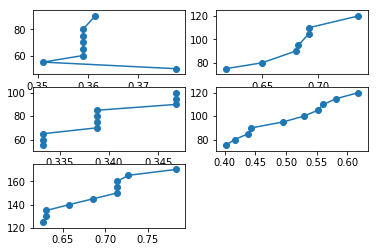

In [317]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.subplot(3,2,1)
plt.plot(CLR[:8],CL[:8])
plt.scatter(CLR[:8],CL[:8])

plt.subplot(3,2,2)
plt.plot(CLR[8:15],CL[8:15])
plt.scatter(CLR[8:15],CL[8:15])

plt.subplot(3,2,3)
plt.plot(CLR[15:25],CL[15:25])
plt.scatter(CLR[15:25],CL[15:25])

plt.subplot(3,2,4)
plt.plot(CLR[25:35],CL[25:35])
plt.scatter(CLR[25:35],CL[25:35])

plt.subplot(3,2,5)
plt.plot(CLR[35:45],CL[35:45])
plt.scatter(CLR[35:45],CL[35:45])

In [318]:
from scipy.optimize import curve_fit
def linear_fit(x, a):
    return a*x
def plot_fit(x, y):
    x_plot = np.arange(0,1,0.01)
    x = np.hstack((x,[0]))
    y = np.hstack((y,[0]))
    popt, pcov = curve_fit(linear_fit, x, y)
    y_plot = linear_fit(x_plot,*popt) #拟合y值
    plt.plot(x, y)
    plt.scatter(x, y)
    plt.plot(x_plot, y_plot)
    return linear_fit(0.98, *popt)


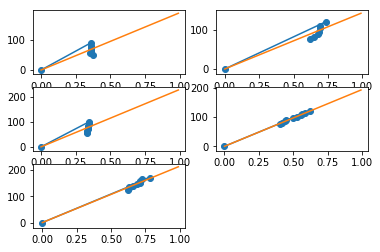

In [319]:
plt.subplot(3,2,1)
y_01 = plot_fit(CLR[:8],CL[:8])

plt.subplot(3,2,2)
y_02 =plot_fit(CLR[8:15],CL[8:15])

plt.subplot(3,2,3)
y_03 =plot_fit(CLR[15:25],CL[15:25])

plt.subplot(3,2,4)
y_04 =plot_fit(CLR[25:35],CL[25:35])

plt.subplot(3,2,5)
y_05 =plot_fit(CLR[35:45],CL[35:45])


In [320]:
y_hat = np.array([y_01, y_02, y_03, y_04, y_05])
y = np.array([194, 172, 290, 186, 210])
print(y_hat)

[184.88100262 140.0086842  224.24600251 189.80924437 210.2807104 ]


In [321]:
def score(ground_truth, pred):
    deltas = ground_truth - pred
    def late(d):
        return np.exp(-np.log(0.5)*(d/5))
    def early(d):
        return np.exp(np.log(0.5)*(d/20))
    result = 0
    for delta in deltas:
        if delta<=0:
            result = result + late(delta)
        else:
            result = result + early(delta)
    return result/len(deltas)

In [322]:
print(100 * score(y, y_hat))

54.25959962367614
